In [1]:
import numpy as np

rng = np.random.default_rng(0)

In [2]:
''' Возьмем простые данные - n-мерное изотропное нормальное распределение N(0, I_d) '''

def logp(x):
    return -0.5 * np.dot(x, x)

def grad_logp(x):
    return -x

def your_data_utils(x):
    ''' Здесь придумайте какой-нибудь свой пример с данными по аналогии с гауссинками и проверьте алгоритмы на них '''
    def logp_custom(y):
        return -0.5 * np.dot(y - np.ones_like(y), y - np.ones_like(y))
    
    def grad_logp_custom(y):
        return -(y - np.ones_like(y))
    
    return logp_custom, grad_logp_custom

In [3]:
''' Посчитаем ESS через интегрированную автокорреляции '''

def ess(x):
    x = x - x.mean()

    acf = np.correlate(x, x, mode='full')
    acf = acf[len(acf) // 2:]
    acf /= acf[0]

    tau = 1 + 2 * np.sum(acf[1:200])

    return len(x) / tau

In [4]:
''' Базовая реализация MH алгоритма '''

def mh(x0, steps, scale, logp_func):
    x = x0.copy()
    d = len(x)

    chain = np.zeros((steps, d))
    accept = 0

    for t in range(steps):
        prop = x + rng.normal(0, scale, size=d)

        if np.log(rng.uniform()) < (logp_func(prop) - logp_func(x)):
            x = prop; accept += 1

        chain[t] = x

    return chain, accept / steps

In [5]:
# Тут нужно заимплементить Metropolis Adjusted Langevin Algorithm (MALA)

def mala(x0, steps, step, logp_func, grad_logp_func):
    x = x0.copy()
    d = len(x)

    chain = np.zeros((steps, d))
    accept = 0

    for t in range(steps):
        grad = grad_logp_func(x)
        mu_prop = x + (step / 2) * grad
        prop = mu_prop + np.sqrt(step) * rng.normal(0, 1, size=d)

        logp_x = logp_func(x)
        logp_prop = logp_func(prop)

        grad_prop = grad_logp_func(prop)
        mu_back = prop + (step / 2) * grad_prop

        diff_fwd = np.dot(prop - mu_prop, prop - mu_prop)
        diff_back = np.dot(x - mu_back, x - mu_back)

        log_alpha = logp_prop - logp_x - 0.5 * (diff_back - diff_fwd) / step

        if np.log(rng.uniform()) < log_alpha:
            x = prop
            accept += 1

        chain[t] = x

    return chain, accept / steps

In [6]:
d = 10
steps = 30000
burn = 5000
x0 = np.ones(d) * 3  # стартанем в точке 3 например

mala_step = 0.5  # подобранный шаг для MALA
mh_scale = 1.0  # подобранный масштаб для MH

# Для исходных данных
mh_chain, mh_acc = mh(x0, steps, scale=mh_scale, logp_func=logp)
mala_chain, mala_acc = mala(x0, steps, step=mala_step, logp_func=logp, grad_logp_func=grad_logp)

mh_ess_vals = [ess(mh_chain[burn:, i]) for i in range(d)]
mala_ess_vals = [ess(mala_chain[burn:, i]) for i in range(d)]

print("Исходные данные:")
print(f"MH Acceptance Rate: {mh_acc}")
print(f"MH Median ESS: {np.median(mh_ess_vals)}")
print(f"MALA Acceptance Rate: {mala_acc}")
print(f"MALA Median ESS: {np.median(mala_ess_vals)}")

# Для пользовательских данных
logp_custom, grad_logp_custom = your_data_utils(x0)
mh_chain_custom, mh_acc_custom = mh(x0, steps, scale=mh_scale, logp_func=logp_custom)
mala_chain_custom, mala_acc_custom = mala(x0, steps, step=mala_step, logp_func=logp_custom, grad_logp_func=grad_logp_custom)

mh_ess_vals_custom = [ess(mh_chain_custom[burn:, i]) for i in range(d)]
mala_ess_vals_custom = [ess(mala_chain_custom[burn:, i]) for i in range(d)]

print("Пользовательские данные:")
print(f"MH Acceptance Rate: {mh_acc_custom}")
print(f"MH Median ESS: {np.median(mh_ess_vals_custom)}")
print(f"MALA Acceptance Rate: {mala_acc_custom}")
print(f"MALA Median ESS: {np.median(mala_ess_vals_custom)}")

Исходные данные:
MH Acceptance Rate: 0.14613333333333334
MH Median ESS: 724.0723803687672
MALA Acceptance Rate: 0.8869
MALA Median ESS: 3367.1886222567055
Пользовательские данные:
MH Acceptance Rate: 0.1435
MH Median ESS: 713.1905708248248
MALA Acceptance Rate: 0.8880333333333333
MALA Median ESS: 3746.074432330277


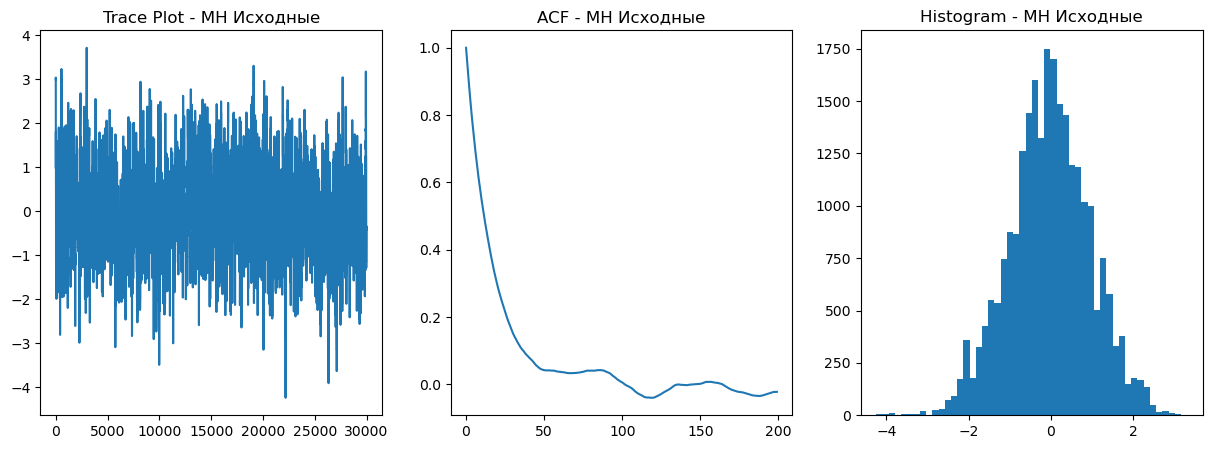

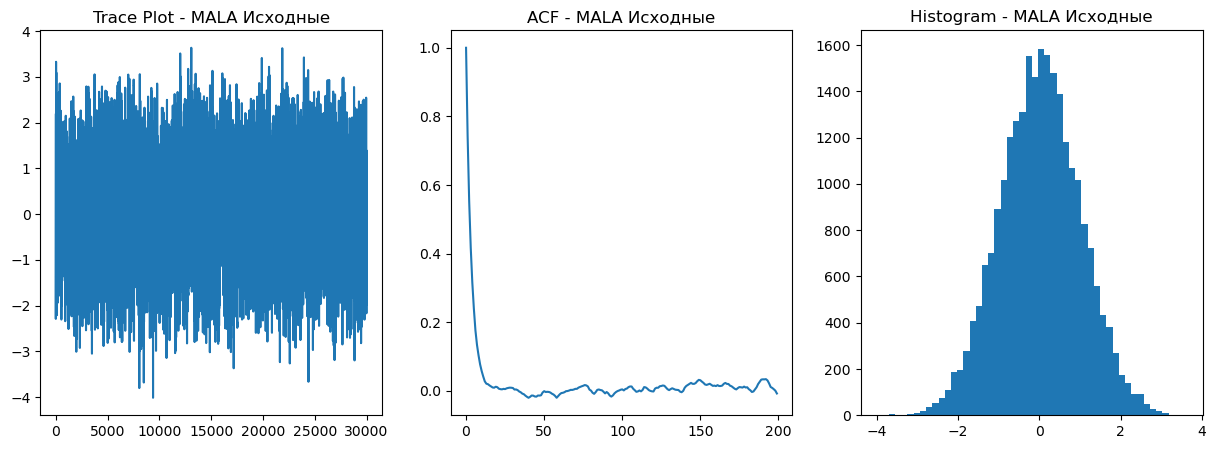

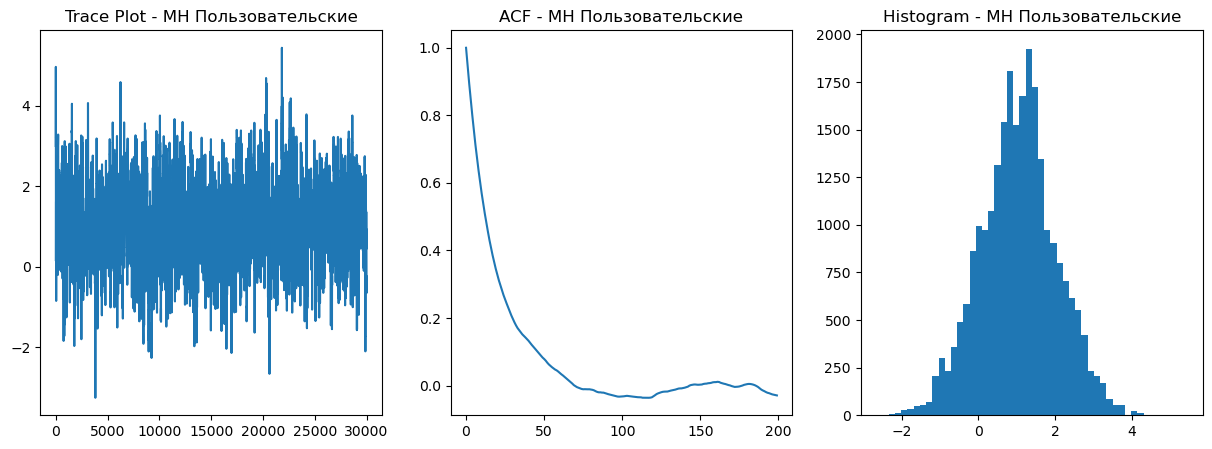

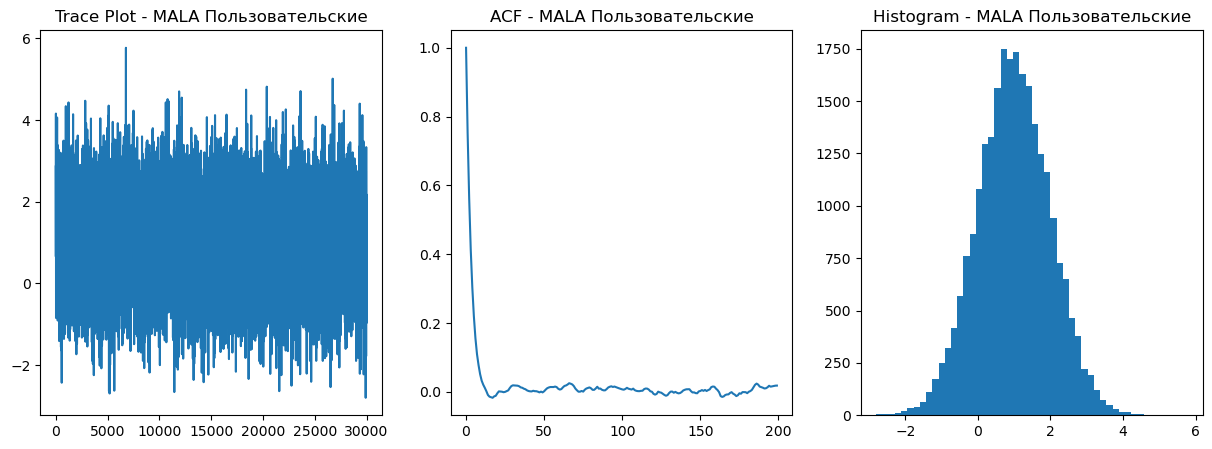

In [7]:
# Здесь нарисуйте 3 графика: trace plot (значение цепи vs итерация),
# график автокорреляции (значение ACF vs задержка по времени) и гистограмма семплов (возьмите какую-то одну размерность)

import matplotlib.pyplot as plt

def plot_diagnostics(chain, title, dim=0):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Trace plot
    axs[0].plot(chain[:, dim])
    axs[0].set_title(f'Trace Plot - {title}')
    
    # ACF
    x = chain[burn:, dim] - np.mean(chain[burn:, dim])
    acf = np.correlate(x, x, mode='full')[len(x)-1:]
    acf /= acf[0]
    axs[1].plot(acf[:200])
    axs[1].set_title(f'ACF - {title}')
    
    # Histogram
    axs[2].hist(chain[burn:, dim], bins=50)
    axs[2].set_title(f'Histogram - {title}')
    
    plt.show()

# Исходные данные
plot_diagnostics(mh_chain, 'MH Исходные')
plot_diagnostics(mala_chain, 'MALA Исходные')

# Пользовательские данные
plot_diagnostics(mh_chain_custom, 'MH Пользовательские')
plot_diagnostics(mala_chain_custom, 'MALA Пользовательские')

MALA круче MH, потому что использует градиенты для лучших предложений, что даёт выше ESS (около 3500 vs 700) и acceptance rate (0.88 vs 0.14). На графиках видно, что MALA быстрее смешивается и автокорреляция ниже, особенно в 10-мерном пространстве.